<a id="top"></a>
# UN SDG Indicator 15.3.1:<br> Proportion of land that is degraded over total land area


<hr>

# Definitions

> **Land degradation** is defined as the reduction or loss of the biological or economic productivity and complexity of rain fed cropland, irrigated cropland, or range, pasture, forest and woodlands resulting from a combination of pressures, including land use and management practices. This definition was adopted by and is used by the 196 countries that are Party to the UNCCD.<sup>1</sup>

> **Total land area** is the total surface area of a country excluding the area covered by inland waters, like major rivers and lakes.<sup>2</sup>

<sup>1</sup> United Nations Convention to Combat Desertification. 1994. Article 1 of the Convention Text http://www2.unccd.int/sites/default/files/relevant-links/2017-01/UNCCD_Convention_ENG_0.pdf

<sup>2</sup> Food and Agriculture Organization of the United Nations

<hr>

# Notebook Summary
The United Nations have prescribed 17 "Sustainable Development Goals" (SDGs). This notebook attempts to monitor SDG Indicator 15.3.1 - the proportion of land that is degraded over total land area.

<hr>

# Index

* [Import Dependencies and Connect to the Data Cube](#import)
* [Choose Platforms and Products](#plat_prod)
* [Get the Extents of the Cube](#extents)
* [Define the Extents of the Analysis](#define_extents)
* [Load the Data](#load_data)
    * Load data from ESA CCI
    * Load data from the Data Cube
* [Train Random Forest Classifier](#train_cls)
    * Train Model
    * Get Model Score and  Predictions
    * Prepare for Visualization
    * Visualize ESA CCI Data for the Beginning and End of the Time Range
    * Visualize Predicted Land Classes (Model), and True Land Classes (ESA)
* [Create Change Matrix](#change_matrix)
* [Calculate Peak NDVI Within Classes](#peak_ndvi_within_class)
* [Determine NDVI Trend](#ndvi_trend)
    * Fit a Thiel-Sen Regressor to the Mean NDVI Across Time
    * Run the Mann-Kendall Test on the Mean NDVI Across Time to Determine the Trend

## <span id="import">Import Dependencies and Connect to the Data Cube [&#9652;](#top)</span> 

In [1]:
%matplotlib inline
import warnings
import matplotlib.pyplot as plt

# Import the datacube and the API
import datacube
from utils.data_cube_utilities.data_access_api import DataAccessApi
import datetime as dt
import numpy as np
import xarray as xr

/home/localuser/Datacube/datacube_env/lib/python3.5/site-packages/psycopg2-2.7.4-py3.5-linux-x86_64.egg/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
# Create an instance of the datacube and API.
api = DataAccessApi(config="/home/localuser/.datacube.conf")
dc = api.dc

## <span id="plat_prod">Choose Platforms and Products [&#9652;](#top)</span>

**List available products for each platform**

In [3]:
# Get available products
products_info = dc.list_products()

# List LANDSAT 7 products
print("LANDSAT 7 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_7"]

LANDSAT 7 Products:


,platform,name
id,,
12,LANDSAT_7,ls7_collections_sr_scene
13,LANDSAT_7,ls7_ledaps_ghana
17,LANDSAT_7,ls7_ledaps_kenya
18,LANDSAT_7,ls7_ledaps_senegal
16,LANDSAT_7,ls7_ledaps_sierra_leone
19,LANDSAT_7,ls7_ledaps_tanzania
31,LANDSAT_7,ls7_ledaps_vietnam


In [4]:
# List LANDSAT 8 products
print("LANDSAT 8 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_8"]

LANDSAT 8 Products:


,platform,name
id,,
7,LANDSAT_8,ls8_collections_sr_scene
9,LANDSAT_8,ls8_lasrc_ghana
10,LANDSAT_8,ls8_lasrc_kenya
11,LANDSAT_8,ls8_lasrc_senegal
8,LANDSAT_8,ls8_lasrc_sierra_leone
15,LANDSAT_8,ls8_lasrc_tanzania


**Choose products**

In [5]:
# These are the platforms (satellites) and products (datacube sets) 
# used for this demonstration.
use_Landsat7 = True
use_Landsat8 = False
platforms = []
products = []
if use_Landsat7:
    platforms.append('LANDSAT_7')
    products.append('ls7_ledaps_ghana')
if use_Landsat8:
    platforms.append('LANDSAT_8')
    products.append('ls8_lasrc_ghana')

## <span id="extents">Get the Extents of the Cube [&#9652;](#top)</span>

In [6]:
from utils.data_cube_utilities.ama_utils.dc_display_map import display_map
from utils.data_cube_utilities.ama_utils.dc_load import get_overlapping_area

# Get the area common to all products.
full_lat, full_lon, min_max_dates = get_overlapping_area(api, platforms, products)
# Display the total shared area available for these datacube products.
display_map(latitude = full_lat,longitude = full_lon)

/home/localuser/Datacube/data_cube_notebooks/utils/data_cube_utilities/data_access_api.py:183: FutureWarning: casting an xarray.Dataset to a boolean will change in xarray v0.11 to only include data variables, not coordinates. Cast the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  if not dataset:


## <span id="define_extents">Define the Extents of the Analysis [&#9652;](#top)</span>

**Specify start and end dates**

In [7]:
print("Start and end dates available to both products:")
for platform, min_max_date in zip(platforms, min_max_dates):
    print("{}:\n{}".format(platform, min_max_date))

Start and end dates available to both products:
LANDSAT_7:
[datetime.datetime(2000, 1, 1, 10, 19, 16)
 datetime.datetime(2017, 12, 28, 10, 11, 43)]


In [8]:
# Select a subset of the time available.
first_year, last_year = 2000, 2015
years = np.arange(first_year,last_year+1)
date_ranges = {year: [dt.datetime(year,1,1), dt.datetime(year,12,31)] for year in years}

**Specify an area to analyze**

In [9]:
# Specify latitude and longitude bounds of an interesting area within the full extents.

# Ghana
# min_lat_small, max_lat_small = (6.5016, 6.5821) # Lake Volta (WOFS Test)
# min_lon_small, max_lon_small = (-0.1618, -0.055) # Lake Volta (WOFS Test)
# min_lat_small, max_lat_small = (6.5138, 6.5292) # Lake Volta (WOFS Test - small)
# min_lon_small, max_lon_small = (-0.1669, -0.1493) # Lake Volta (WOFS Test - small)
# min_lat_small, max_lat_small = (10.0, 11.0) # NE Ghana (Land Change)
# min_lon_small, max_lon_small = (-0.9, -0.1) # NE Ghana (Land Change)
# min_lat_small, max_lat_small = (10.45, 10.55) # NE Ghana (Land Change - small)
# min_lon_small, max_lon_small = (-0.55, -0.45) # NE Ghana (Land Change - small)
# min_lat_small, max_lat_small = (4.7680, 6.0000) # S Ghana (Land Change - #1)
# min_lon_small, max_lon_small = (-2.5405, 1.1110) # S Ghana (Land Change - #1)
min_lat_small, max_lat_small = (5.3180, 5.5500) # S Ghana (Land Change - #2)
min_lon_small, max_lon_small = (-0.6505,-0.4110) # S Ghana (Land Change - #2)

**Visualize the selected area**

In [10]:
from utils.data_cube_utilities.ama_utils.dc_display_map import display_map
lon_small = (min_lon_small, max_lon_small)
lat_small = (min_lat_small, max_lat_small)
display_map(lat_small, lon_small)

## <span id="load_data">Load the Data [&#9652;](#top)</span>

In [11]:
## Constants ##
# Resolution of the ESA CCI land classification data.
ESA_CCI_RES = np.array([-0.002777777777778, 0.002777777777778])

### Load Data from ESA CCI [&#9652;](#top)

In [12]:
import rasterio
import numpy as np

def load_ESA_CCI_data(fp='ESA_CCI/ESACCI-LC-L4-LCCS-Map-300m-P1Y-1992_2015-v2.0.7.tif',
                      years=None, lat=None, lon=None, num_lat=None, num_lon=None):
    """
    Loads ESA CCI data from a file path to a GeoTIFF. It is yearly data from 1992-2015 at 300m resolution 
    containing land classifications from the UN Land Cover Classification SYstem (LCCS) 
    (http://www.fao.org/land-water/land/land-governance/land-resources-planning-toolbox/category/details/en/c/1036361/).

    The data covers the entire world with a latitude range of (-90, 90) and a longitude range of (-180, 180).

    Parameters
    ----------
    fp: str
        The string filepath to a GeoTIFF containing 24 years of data - 1992-2015.
    years: list of int
        The years to retrieve data for.
    lat, lon: list
        Lists of latitude and longitude minimum and maximum values.
        The latitude extents are (-90, 90). The longitude extents are (-180, 180).
    num_lat, num_lon:
        The number of values in the latitude and longitude dimensions to acquire.
    """
    def load_data_np_arr():
        with rasterio.open(fp, driver='GTiff') as dst:
            data_np_arr = dst.read(indexes=year_inds, window=(list(lat_px_inds), list(lon_px_inds)))
            dst.close()
        return data_np_arr
    
    assert years is not None, "years must be specified"
    assert lat is not None, "lat must be specified."
    assert lon is not None, "lon must be specified."

    (MIN_LAT, MAX_LAT), (MIN_LON, MAX_LON) = (-90, 90), (-180, 180)
    DEGREE_PER_PX = np.abs(ESA_CCI_RES)
    PX_PER_DEGREE = 1/DEGREE_PER_PX # About 360.
    years, lat, lon = np.array(years), np.array(lat), np.array(lon)
    
    # Select years.
    year_inds = list(years-1991)
    # Select area.
    # Latitude pixel indices are handled differently than longitude because 
    # latitude indexing is from top to bottom in this dataset.
    lat_px_inds = np.round(PX_PER_DEGREE[0]*(MAX_LAT - lat)).astype(np.int32)[::-1]
    lon_px_inds = np.round(PX_PER_DEGREE[1]*(lon - MIN_LON)).astype(np.int32)
    
    data_np_arr = load_data_np_arr() # Load the data.
    # Determine latitude and longitude coordinates.
    lat, lon = np.arange(*lat, DEGREE_PER_PX[0])[::-1], np.arange(*lon, DEGREE_PER_PX[1])
    # Handle too many coordinates ("one-off" errors).
    lat, lon = lat[:data_np_arr.shape[1]], lon[:data_np_arr.shape[2]]
    return xr.DataArray(data=data_np_arr, coords=[years, lat, lon], dims=['time', 'latitude', 'longitude'])
        
esa_data = load_ESA_CCI_data(years=years, lat=lat_small, lon=lon_small)

### Load Data from the Data Cube [&#9652;](#top)

In [13]:
from utils.data_cube_utilities.ama_utils.dc_load import load_multiplatform
from utils.data_cube_utilities.ama_utils.dc_ndvi_anomaly import NDVI
from utils.data_cube_utilities.ama_utils.dc_mosaic import create_hdmedians_multiple_band_mosaic

datacube_geomedian_data = []
datacube_ndvi_data = []
measurements = ['red', 'blue', 'green', 'nir', 'swir1', 'swir2', 'pixel_qa']
for date_range in date_ranges.values():
    dataset_temp, clean_mask_temp, masks = \
        load_multiplatform(dc, platforms, products, 
            abs_res=(len(esa_data.longitude), len(esa_data.latitude)),
            load_params=dict(lat=lat_small, lon=lon_small, time=date_range, measurements=measurements))
    cleaned_dataset_temp = dataset_temp.where(clean_mask_temp)
    datacube_ndvi_data.append(NDVI(cleaned_dataset_temp.mean(dim=['latitude', 'longitude', 'time'])))
    datacube_geomedian_data.append(create_hdmedians_multiple_band_mosaic(dataset_temp, clean_mask_temp))

In [14]:
datacube_ndvi_data = xr.concat(datacube_ndvi_data, dim='time')
datacube_ndvi_data.coords['time'] = years
datacube_geomedian_data = xr.concat(datacube_geomedian_data, dim='time')
datacube_geomedian_data.coords['time'] = years

## <span id="train_cls">Train Random Forest Classifier [&#9652;](#top)</span>

### Train Model [&#9652;](#top)

In [15]:
from collections import OrderedDict
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer

from utils.data_cube_utilities.ama_utils.dc_utilities import reverse_array_dict

# For the feature matrix, make one row for the band values for each pixel for each year.
datacube_geomedian_data_arr = datacube_geomedian_data.to_array(dim='data_var').\
                              transpose('time', 'latitude', 'longitude', 'data_var').values
num_data_vars = datacube_geomedian_data_arr.shape[-1]
datacube_geomedian_data_arr_features = \
    datacube_geomedian_data_arr.reshape((-1,num_data_vars))

# Encode data as 6 IPCC land categories.
# See the ECA CCI Quick User Guide for these codes and their more detailed meanings.
esa_values_for_label = OrderedDict([ # For a label, returns all possible ESA CCI values.
    ('Forest Land', np.array([50, 60, 61, 62, 70, 71, 72, 80, 81, 82, 90, 100])),
    ('Grassland', np.array([40, 120, 121, 122, 130, 140, 150, 152, 153])),
    ('Cropland', np.array([10, 11, 12, 20, 30, 110])),
    ('Wetlands', np.array([160, 170, 180])),
    ('Settlements', np.array([190])),
    ('Other Land', np.array([200, 201, 202, 210, 220])),
    ('No Data', np.array([0]))
])
# For an ESA CCI value, returns the corresponding label.
esa_label_for_value = reverse_array_dict(esa_values_for_label)

# Encode the data.
esa_data_encoded = esa_data.copy() #np.empty_like(esa_data.values)
for i, (cls_label, values_for_label) in enumerate(esa_values_for_label.items()):
    esa_data_encoded.values[np.isin(esa_data.values, values_for_label)] = i

# Flatten ESA data to use as class labels.
esa_data_arr_encoded = esa_data_encoded.transpose('time', 'latitude', 'longitude').values

# Select only pixels which have valid ESA CCI data.
datacube_geomedian_data_arr = datacube_geomedian_data_arr[esa_data_arr_encoded != 6]
esa_data_arr_encoded_flat = esa_data_arr_encoded[esa_data_arr_encoded != 6]

# Train the model.
X, y = datacube_geomedian_data_arr_features, esa_data_arr_encoded_flat
# Remove corresponding entries in `X` and `y` where either has NaN values.
no_nan_mask = (~np.isnan(X).any(axis=1)) & ~np.isnan(y)
X_no_nan, y_no_nan = X[no_nan_mask], y[no_nan_mask]
param_grid = {
    'n_estimators': [10]
}
num_folds = 5
grid_search = GridSearchCV(RandomForestClassifier(), param_grid,
                           scoring=make_scorer(accuracy_score), cv=num_folds)
grid_search.fit(X_no_nan, y_no_nan)
model, score, best_params = grid_search.best_estimator_, grid_search.best_score_, grid_search.best_params_

In [16]:
print("The best parameter set was:", best_params)

The best parameter set was: {'n_estimators': 10}


### Get Model Score and Predictions [&#9652;](#top)

In [17]:
# Make predictions.
y_pred_no_nan = model.predict(X_no_nan)

# Evaluate performance.
print("Model Cross Validation Score: {0:0.6%} (Stratified {1}-fold)".format(score, num_folds))
print("Model Accuracy: {0:0.6%}".format(accuracy_score(y_no_nan, y_pred_no_nan)))

Model Cross Validation Score: 91.273277% (Stratified 5-fold)
Model Accuracy: 99.273963%


### Prepare for Visualization [&#9652;](#top)

In [18]:
from utils.data_cube_utilities.ama_utils.plotter_utils import figure_ratio, xarray_imshow, \
                                                              create_discrete_color_map

# Determine the class labels to use in visualizations.
esa_values_for_label_copy = esa_values_for_label.copy()
esa_values_for_label_copy.pop('No Data', None)
classes = np.array(list(esa_values_for_label_copy.keys()))
num_classes = len(classes)

# Reshape land class predictions for visualization.
y_pred = np.empty_like(y, dtype=np.float64)
y_pred[no_nan_mask] = y_pred_no_nan
y_pred[~no_nan_mask] = np.nan
dim_lengths_shape = esa_data_encoded.shape
y_pred_3D = xr.DataArray(data=y_pred.reshape(dim_lengths_shape), coords=esa_data_encoded.coords, 
                         dims=esa_data_encoded.dims, attrs=esa_data_encoded.attrs)

# Specify the size of axes elements in the following plots.
get_base_figsize = lambda num_cols: figure_ratio(datacube_geomedian_data, fixed_width=24/num_cols)

# Get a mapping of values to labels for legend labelling.
legend_labels = {value:label for value, label in enumerate(classes)}
# Create a colormap for the predicted and true land classes.
map_cmap = create_discrete_color_map((0, len(classes)-1), 
                                 colors=['red', 'yellow', 'green', 'blue', 'brown', 'black'])
# Create a colormap for coloring the cells in the change matrix.
change_matrix_cmap = create_discrete_color_map([-1,1], colors=[(255, 204, 204), (189, 215, 238), (198, 224, 180)])

title_fontdict = dict(fontsize=24) # Title formatting
tick_label_fmt_dict = dict(axis='both', labelsize=16) # Tick label formatting
axis_label_fmt_dict = dict(fontsize=20) # Axis label formatting
legend_kwargs = dict(fontsize=16, framealpha=0.4)
std_dpi = 200 # Standard image dpi.

### Visualize ESA CCI Data for the Beginning and End of the Time Range [&#9652;](#top)

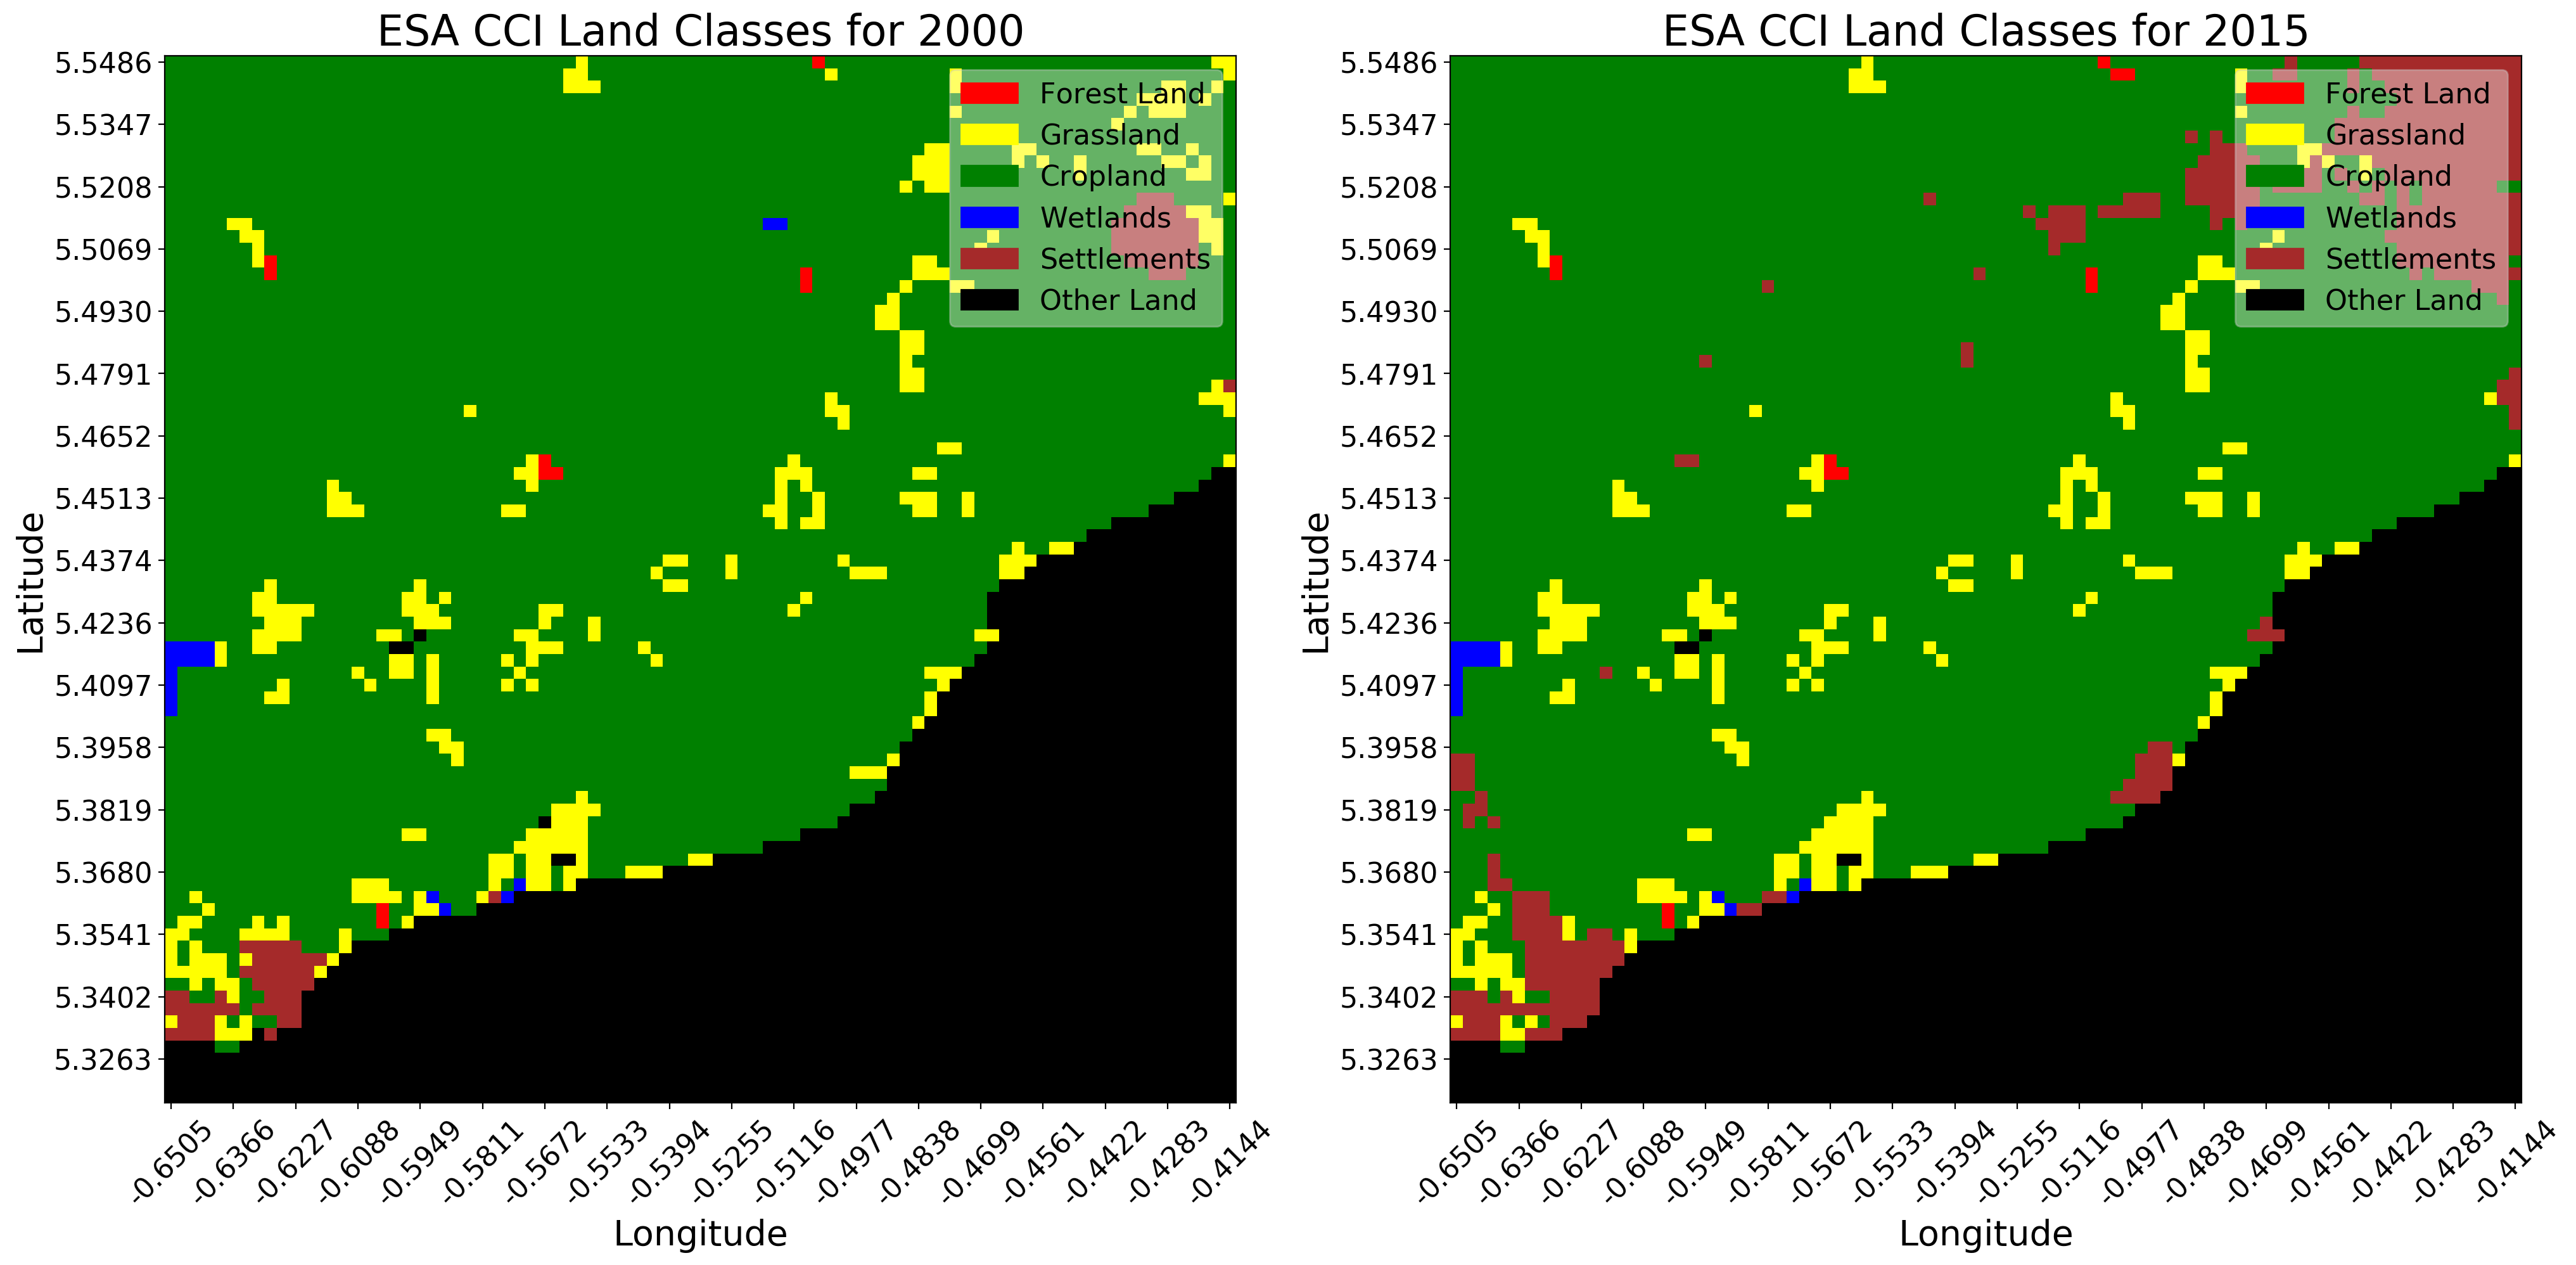

In [19]:
# Show true ESA CCI land classes for the first and last years.
num_rows, num_cols = 1, 2
figsize = [base*num for base,num in zip(get_base_figsize(num_cols), (num_cols, num_rows))]
fig, ax = plt.subplots(num_rows, num_cols, figsize=figsize, dpi=std_dpi)
fig, ax[0], im, cbar = \
xarray_imshow(esa_data_encoded.sel(time=first_year), fig=fig, ax=ax[0],
              use_colorbar=False, use_legend=True, imshow_kwargs=dict(cmap=map_cmap), 
              x_label_kwargs=axis_label_fmt_dict, 
              y_label_kwargs=axis_label_fmt_dict, 
              legend_labels=legend_labels, legend_kwargs=legend_kwargs)
ax[0].set_title("ESA CCI Land Classes for {}".format(first_year), fontdict=title_fontdict)
ax[0].tick_params(**tick_label_fmt_dict)
fig, ax[1], im, cbar = \
    xarray_imshow(esa_data_encoded.sel(time=last_year), fig=fig, ax=ax[1],
                  use_colorbar=False, use_legend=True, imshow_kwargs=dict(cmap=map_cmap), 
                  x_label_kwargs=axis_label_fmt_dict, 
                  y_label_kwargs=axis_label_fmt_dict, 
                  legend_labels=legend_labels, legend_kwargs=legend_kwargs)
ax[1].set_title("ESA CCI Land Classes for {}".format(last_year), fontdict=title_fontdict)
ax[1].tick_params(**tick_label_fmt_dict)

### Visualize Predicted Land Classes (Model), and True Land Classes (ESA) [&#9652;](#top)

**Note that white pixels in the predicted figure are due to missing or masked data, which includes regions occluded by clouds.**

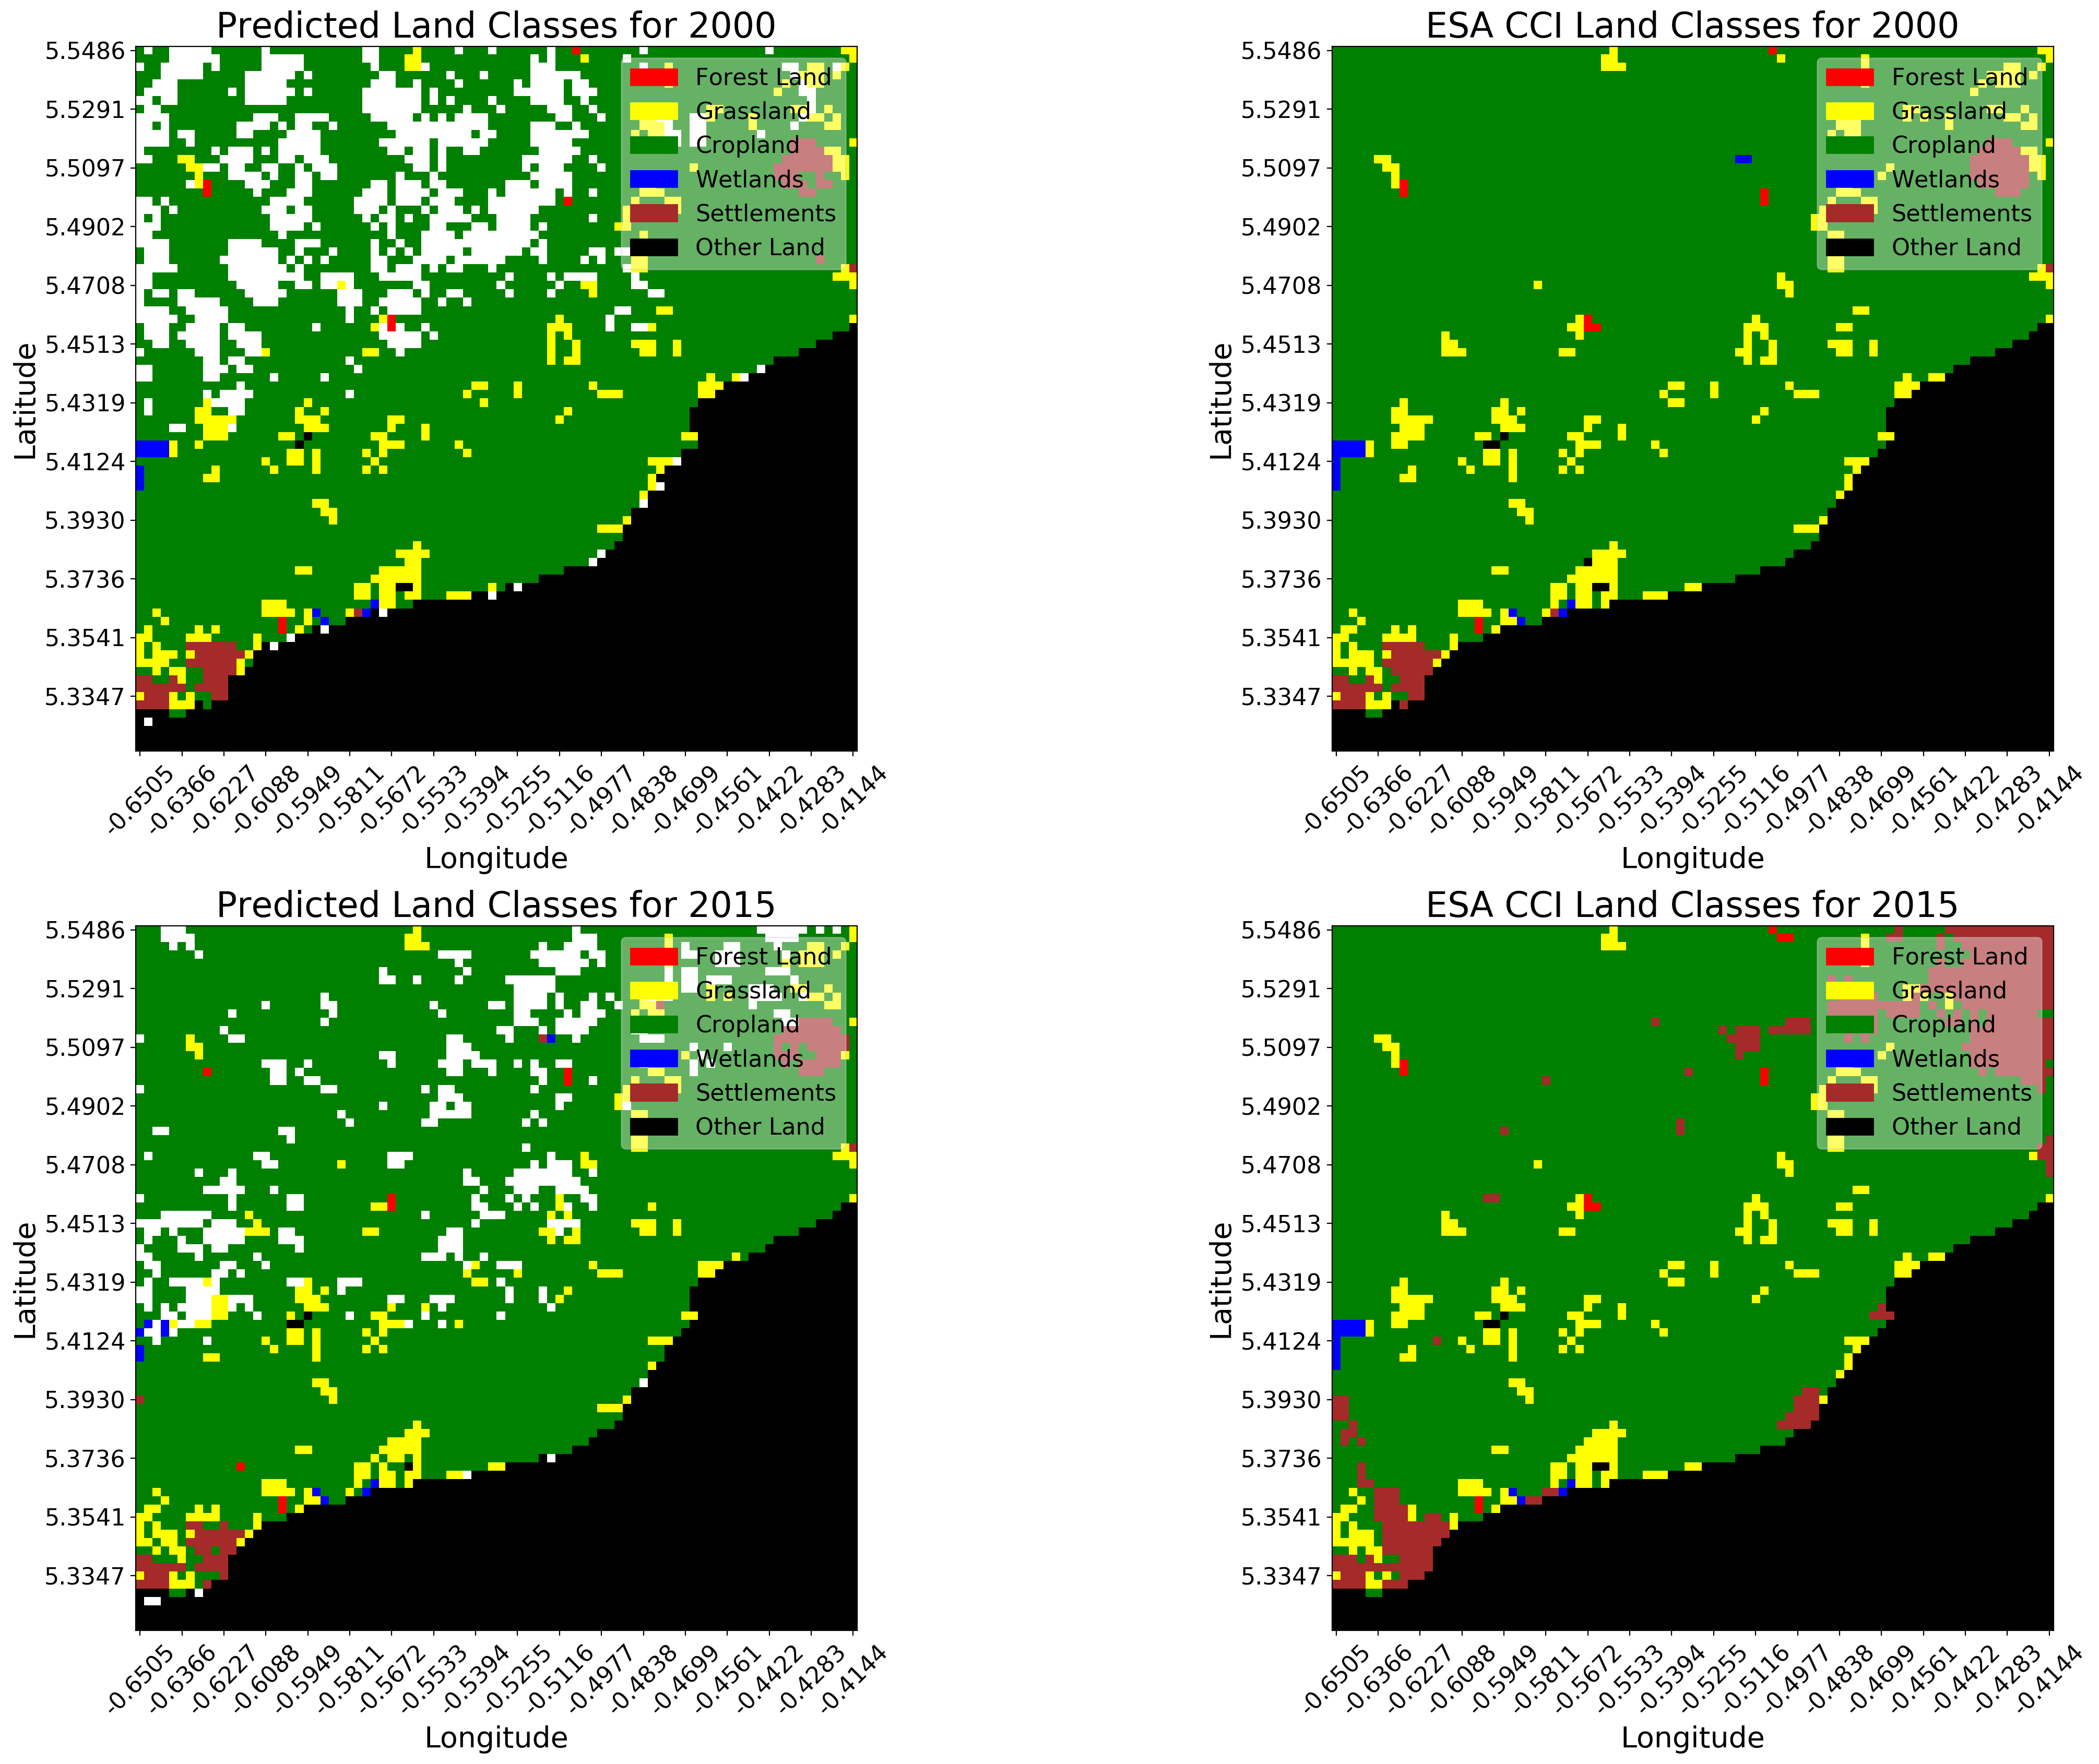

In [20]:
# Show predicted and true ESA CCI land classes side-by-side for some years.
years_to_show = years[0], years[-1] # Select the years you wish to examine.
for year in years_to_show:
    assert year in esa_data.time.values, \
        "The year {} has not been loaded. Only include years "\
        "in the variable 'years_to_show' which are also in the variable 'years'.".format(year)

num_rows, num_cols = len(years_to_show), 2
# Make some space for titles, tick labels, and axis labels.
base_figsize = (12,8.5)

figsize = [base*num for base,num in zip(base_figsize, (num_cols, num_rows))]#zip(get_base_figsize(num_cols), (num_cols, 1.15*num_rows))]
fig = plt.figure(figsize=figsize, dpi=std_dpi)
for year_ind, year in enumerate(years_to_show):
    # Show the predicted ESA CCI land classes on the left.
    ax = fig.add_subplot(num_rows, num_cols, num_cols*year_ind+1)
    fig, ax, im, cbar = \
        xarray_imshow(y_pred_3D[year_ind], fig=fig, ax=ax, use_colorbar=False, use_legend=True, 
                      imshow_kwargs=dict(cmap=map_cmap), x_label_kwargs=axis_label_fmt_dict, 
                      y_label_kwargs=axis_label_fmt_dict,
                      legend_labels=legend_labels, legend_kwargs=legend_kwargs)
    ax.set_title("Predicted Land Classes for {}".format(year), fontdict=title_fontdict)
    ax.tick_params(**tick_label_fmt_dict)
    # Show the true ESA CCI land classes on the right.
    ax = fig.add_subplot(num_rows, num_cols, num_cols*year_ind+2)
    fig, ax, im, cbar = \
        xarray_imshow(esa_data_encoded.sel(time=year), fig=fig, ax=ax, use_colorbar=False, 
                      use_legend=True, imshow_kwargs=dict(cmap=map_cmap), 
                      x_label_kwargs=axis_label_fmt_dict, 
                      y_label_kwargs=axis_label_fmt_dict,
                      legend_labels=legend_labels, legend_kwargs=legend_kwargs)
    ax.set_title("ESA CCI Land Classes for {}".format(year), fontdict=title_fontdict)
    ax.tick_params(**tick_label_fmt_dict)
plt.tight_layout()
plt.show()

## <span id="change_matrix">Create Change Matrix [&#9652;](#top)</span>

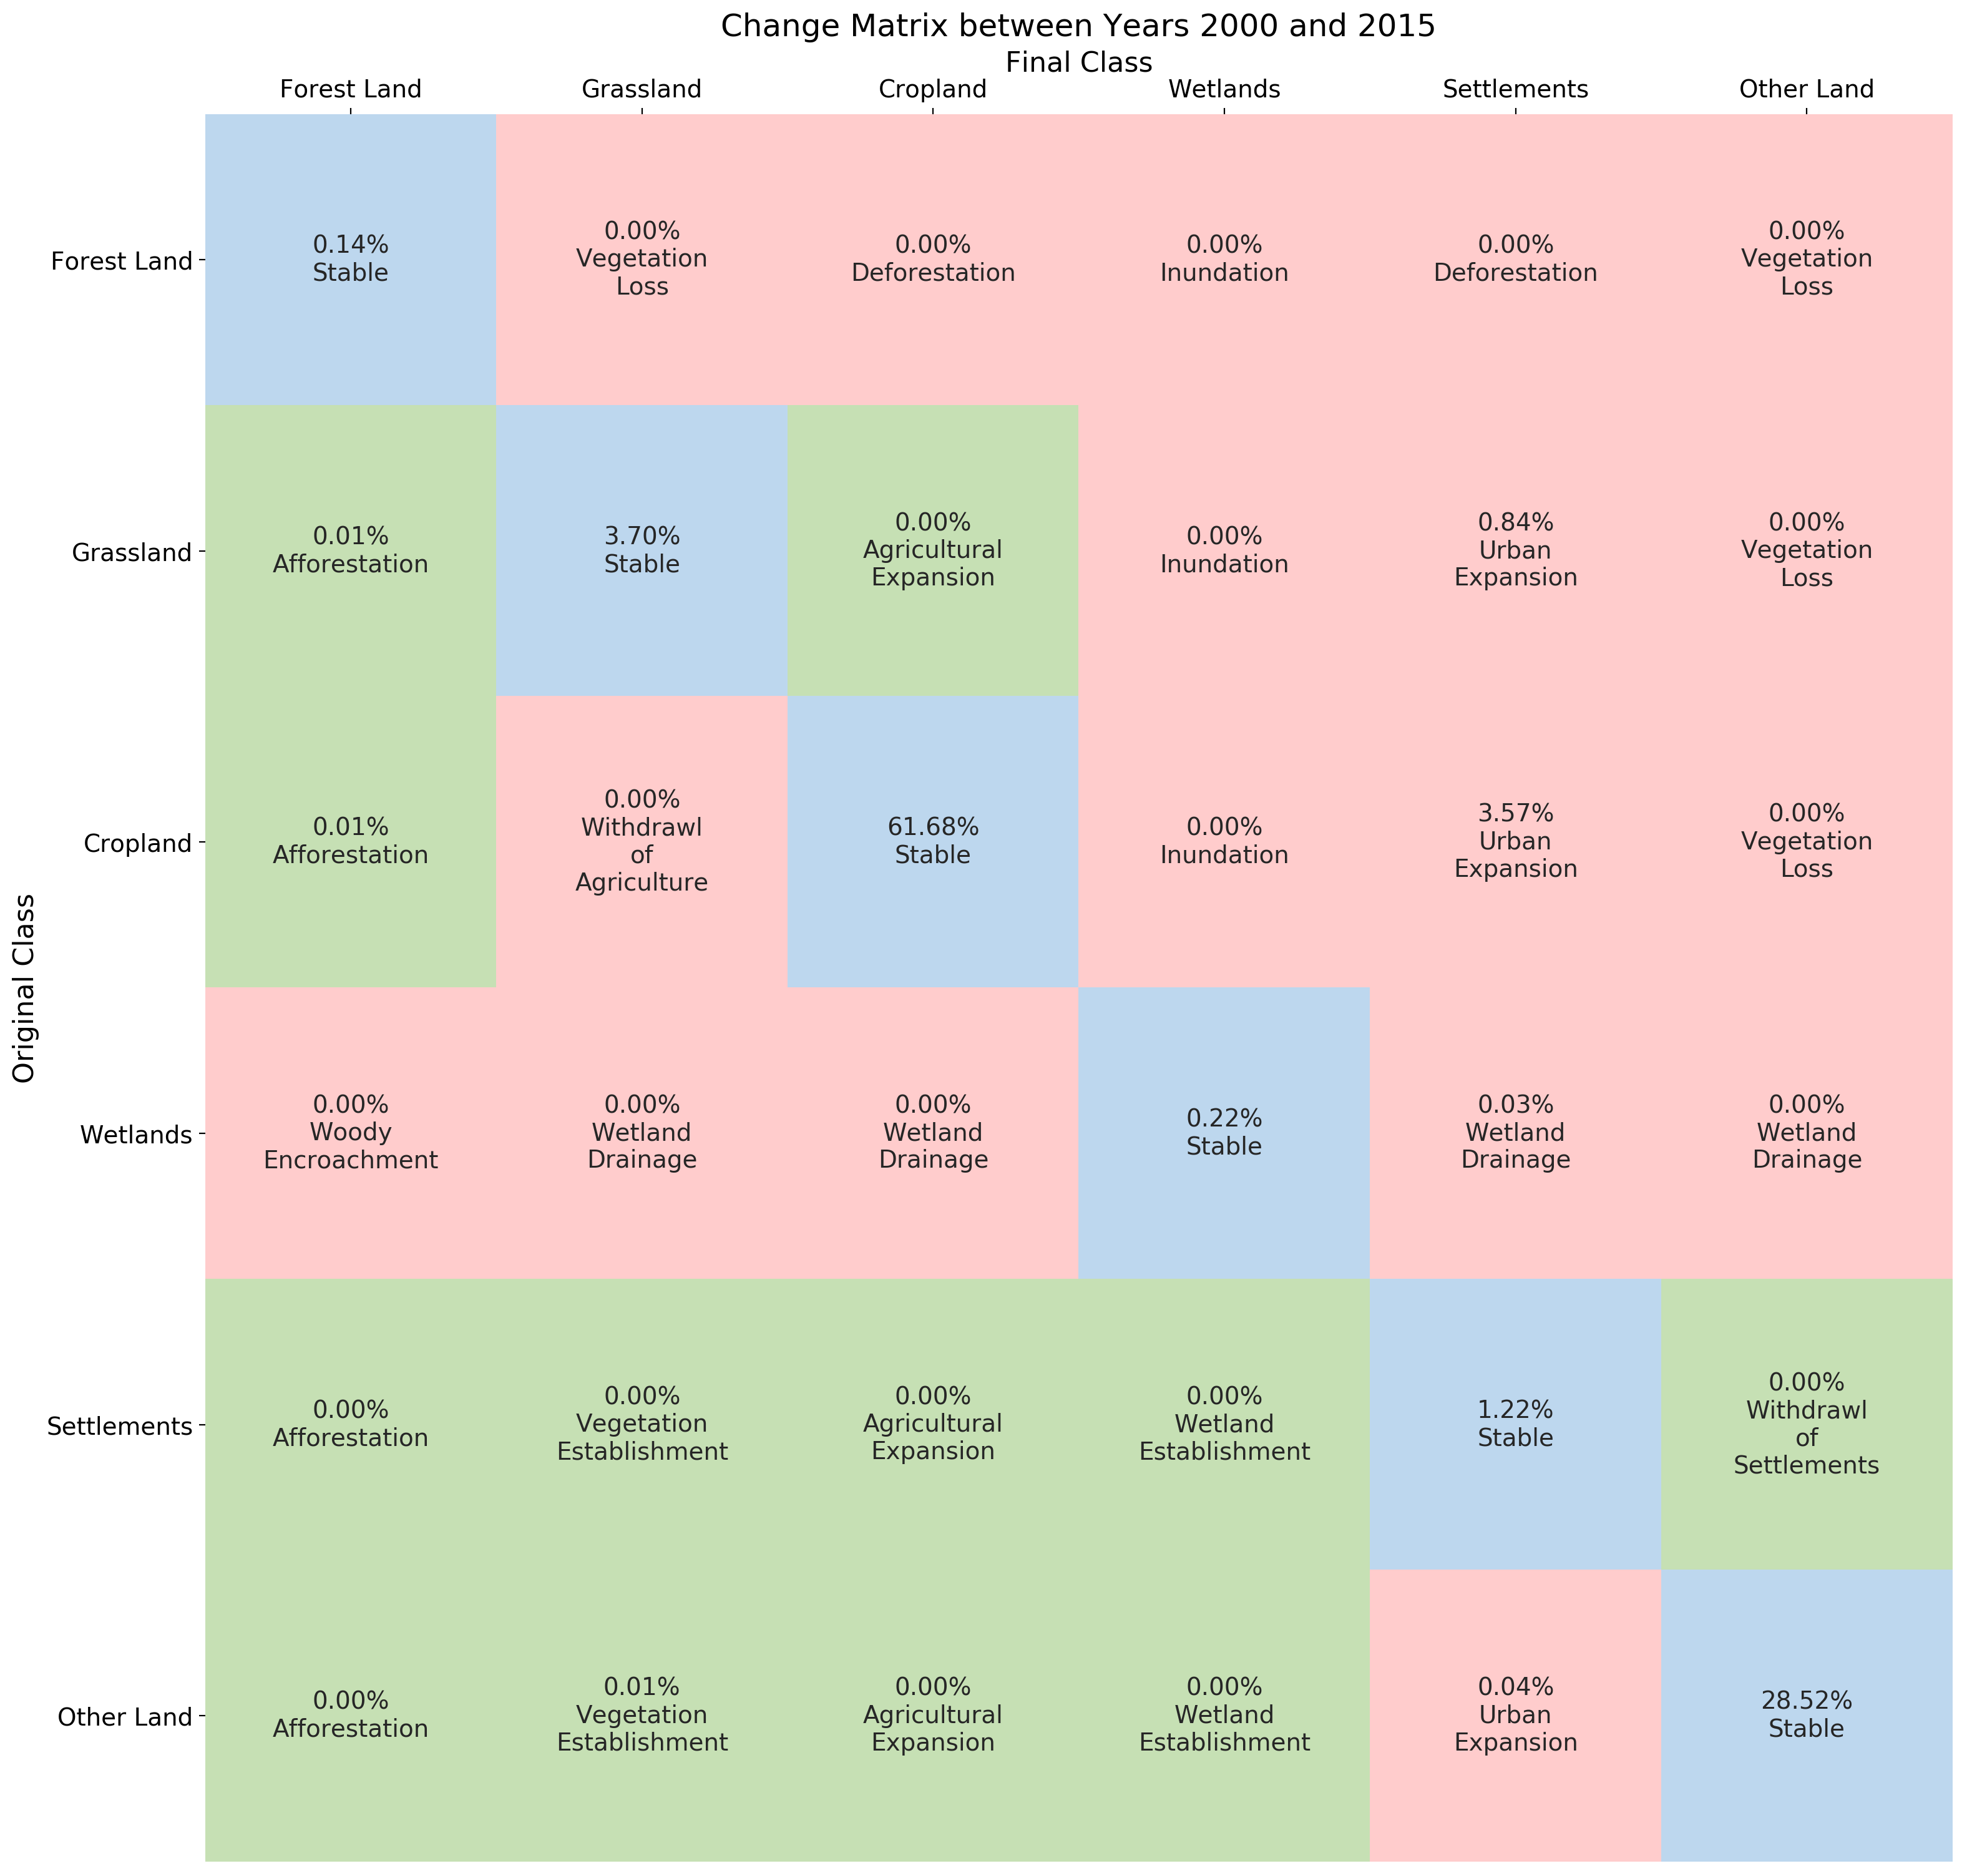

In [21]:
from utils.data_cube_utilities.ama_utils.plotter_utils import print_matrix

# Get class values for the first and last year.
original_year_classes = esa_data_encoded.sel(time=first_year).transpose('latitude', 'longitude').values.flatten()
final_year_classes = esa_data_encoded.sel(time=last_year).transpose('latitude', 'longitude').values.flatten()

# Select only pixels which have valid ESA CCI data.
valid_mask = (original_year_classes != 6) & (final_year_classes != 6)
original_year_classes, final_year_classes = original_year_classes[valid_mask], final_year_classes[valid_mask]

# Get 2-tuples of (original_class, final_class), fill out the change matrix,then convert to percentages of total pixels.
original_final_cls = np.stack([original_year_classes, final_year_classes], axis=1)
change_matrix = np.zeros((num_classes, num_classes), dtype=np.int32)
for orig_cls, final_cls in original_final_cls:
    change_matrix[orig_cls, final_cls] += 1
change_matrix = change_matrix / change_matrix.sum()

# Create mappings of transitions to values for coloring based on a colormap.
neg_cng_val, neu_cng_val, pos_cng_val = -1, 0, 1
cls_trans_for_value = { 
    pos_cng_val: [('Grassland', 'Forest Land'), ('Grassland', 'Cropland'), # Positive change
                  ('Cropland', 'Forest Land'), ('Settlements', 'Forest Land'),
                  ('Settlements', 'Grassland'), ('Settlements', 'Cropland'),
                  ('Settlements', 'Wetlands'), ('Settlements', 'Other Land'),
                  ('Other Land', 'Forest Land'), ('Other Land', 'Grassland'),
                  ('Other Land', 'Cropland'), ('Other Land', 'Wetlands')],
    neu_cng_val: [('Forest Land', 'Forest Land'), ('Grassland', 'Grassland'), # Neutral change
                  ('Cropland', 'Cropland'), ('Wetlands', 'Wetlands'), 
                  ('Settlements', 'Settlements'), ('Other Land', 'Other Land')],
    neg_cng_val: [('Forest Land', 'Grassland'), ('Forest Land', 'Cropland'), # Negative change
                  ('Forest Land', 'Wetlands'), ('Forest Land', 'Settlements'),
                  ('Forest Land', 'Other Land'), ('Grassland', 'Wetlands'), 
                  ('Grassland', 'Settlements'), ('Grassland', 'Other Land'),
                  ('Cropland', 'Grassland'), ('Cropland', 'Wetlands'),
                  ('Cropland', 'Settlements'), ('Cropland', 'Other Land'),
                  ('Wetlands', 'Forest Land'), ('Wetlands', 'Grassland'),
                  ('Wetlands', 'Cropland'), ('Wetlands', 'Settlements'),
                  ('Wetlands', 'Other Land'), ('Other Land', 'Settlements')]
}
value_for_cls_trans = reverse_array_dict(cls_trans_for_value)

# Create mappings of transitions to transition type labels (e.g. "Afforestation").
cls_trans_for_label = {
    "Stable": [('Forest Land', 'Forest Land'), ('Grassland', 'Grassland'),
               ('Cropland', 'Cropland'), ('Wetlands', 'Wetlands'),
               ('Settlements', 'Settlements'), ('Other Land', 'Other Land')],
    "Vegetation Loss": [('Forest Land', 'Grassland'), ('Forest Land', 'Other Land'),
                        ('Grassland', 'Other Land'), ('Cropland', 'Other Land')],
    "Deforestation": [('Forest Land', 'Cropland'), ('Forest Land', 'Settlements'), 
                      ],
    "Inundation": [('Forest Land', 'Wetlands'), ('Grassland', 'Wetlands'), 
                   ('Cropland', 'Wetlands')],
    "Afforestation": [('Grassland', 'Forest Land'), ('Cropland', 'Forest Land'),
                      ('Settlements', 'Forest Land'), ('Other Land', 'Forest Land')],
    "Agricultural Expansion": [('Grassland', 'Cropland'), ('Settlements', 'Cropland'),
                               ('Other Land', 'Cropland')],
    "Urban Expansion": [('Grassland', 'Settlements'), ('Cropland', 'Settlements'),
                        ('Other Land', 'Settlements')],
    "Withdrawl of Agriculture": [('Cropland', 'Grassland')],
    "Woody Encroachment": [('Wetlands', 'Forest Land')],
    "Wetland Drainage": [('Wetlands', 'Grassland'), ('Wetlands', 'Cropland'), 
                         ('Wetlands', 'Settlements'), ('Wetlands', 'Other Land')],
    "Vegetation Establishment": [('Settlements', 'Grassland'), ('Other Land', 'Grassland')],
    "Wetland Establishment": [('Settlements', 'Wetlands'), ('Other Land', 'Wetlands')],
    "Withdrawl of Settlements": [('Settlements', 'Other Land')],
}
cls_label_for_trans = reverse_array_dict(cls_trans_for_label)

# Create the cell value matrix (used to color cells).
cell_value_mtx = np.empty_like(change_matrix)
for i, cls_label1 in enumerate(classes):
    for j, cls_label2 in enumerate(classes):
        cell_value_mtx[i,j] = value_for_cls_trans[(cls_label1, cls_label2)]
        
# Create the cell label matrix.
cell_label_mtx = np.empty_like(change_matrix, dtype=object)
for i, cls_label1 in enumerate(classes):
    for j, cls_label2 in enumerate(classes):
        cell_label_mtx[i,j] = \
            "{0:.2%}\n{1}".format(change_matrix[i,j], 
                                  cls_label_for_trans[(cls_label1, cls_label2)].replace(" ", "\n"))

fig = plt.figure(figsize=(14,14), dpi=std_dpi)

# Show the change matrix
fig, ax = print_matrix(cell_value_mtx=cell_value_mtx, cell_label_mtx=cell_label_mtx, 
                       row_labels=classes, col_labels=classes, cmap=change_matrix_cmap, 
                       cell_val_fmt='s', annot_kwargs=dict(size=14), 
                       x_axis_tick_kwargs=dict(rotation=0), x_axis_ticks_position='top', fig=fig)
ax.yaxis.set_label_position('left')
plt.ylabel('Original Class', fontsize=16)
ax.xaxis.set_label_position('top')
plt.xlabel('Final Class', fontsize=16)
plt.title('Change Matrix between Years {} and {}'.format(first_year, last_year), fontsize=18, pad=45)
plt.show()

## <span id="peak_ndvi_within_class">Calculate Peak NDVI Within Classes [&#9652;](#top)</span>

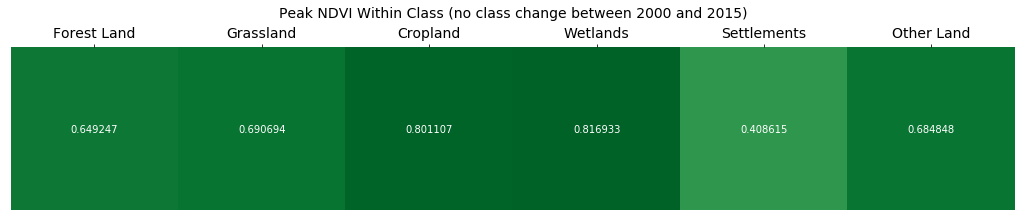

In [22]:
# Get class values for the first and last year.
datacube_original_year_data_arr = NDVI(datacube_geomedian_data.sel(time=first_year)[['nir', 'red']]).\
                                  transpose('latitude', 'longitude').values.flatten()
datacube_final_year_data_arr = NDVI(datacube_geomedian_data.sel(time=last_year)[['nir', 'red']]).\
                               transpose('latitude', 'longitude').values.flatten()
    
# Calculate the maximum NDVI for all pixels that are the same class in the first and final years.
max_ndvi_per_class = np.zeros(num_classes)
for i in range(num_classes):
    stable_mask = np.all(original_final_cls == i, axis=1)
    class_ndvi_vals = datacube_original_year_data_arr[stable_mask]
    max_ndvi_per_class[i] = np.nanmax(class_ndvi_vals) if len(class_ndvi_vals) > 0 else np.nan

width = min(18, 3*num_classes)
height = width/num_classes
print_matrix(max_ndvi_per_class.reshape(1,-1), show_row_labels=False, 
             col_labels=classes, cmap='Greens', x_axis_tick_kwargs=dict(rotation=0), 
             x_axis_ticks_position='top', heatmap_kwargs=dict(vmin=-1, vmax=1), 
             fig_kwargs=dict(figsize=(width,height)))
plt.title('Peak NDVI Within Class (no class change between {} and {})'.format(first_year, last_year), 
          fontsize=14, pad=30)
plt.show()

## <span id="ndvi_trend">Determine NDVI Trend [&#9652;](#top)</span>

### Fit a Thiel-Sen Regressor to the Mean NDVI Across Time [&#9652;](#top)

In [23]:
regressor_X = datacube_ndvi_data.values
regressor_time_pre_fmt = datacube_ndvi_data.time.values
regressor_time = regressor_time_pre_fmt.reshape(-1,1)

from sklearn.linear_model import TheilSenRegressor
regressor = TheilSenRegressor().fit(regressor_time, regressor_X)

### Run the Mann-Kendall Test on the Mean NDVI Across Time to Determine the Trend [&#9652;](#top)

In [24]:
def mann_kendall_test(t, x):
    """
    Runs the Mann-Kendall test to determine a trend in time series data.
    
    This function is a modified form of the function defined here:
        https://up-rs-esp.github.io/mkt/_modules/mkt.html#test
    Documentation used includes: 
        https://up-rs-esp.github.io/mkt/

    Parameters
    ----------
    t : 1D numpy.ndarray
        Array of the time points of measurements.
    x : 1D numpy.ndarray
        Array containing the measurements corresponding to entries of 't'.

    Returns
    -------
    Z_mk: float
        The Z-score statistic for the Mann-Kendall test.
    """
    # Calculate signs of all possible differences x_j - x_k, where j > k.
    n = len(t)
    sgn = np.full(int((n-1)*n/2), 10)
    ind = 0
    for j in range(n-1):
        sgn[ind:ind+(n-1-j)] = np.sign(x[j+1:] - x[j])
        ind += n-1-j
    
    # Calculate the mean of the signs of the differences.
    S_mean = sgn.sum()
    
    # Calculate the variance of the signs of the differences.
    unique_x = np.unique(x)
    num_tie_groups = len(unique_x)
    tie_coef = 0
    if num_tie_groups < len(x): # Calculate the tie group coefficient.
        for tie_ind in range(num_tie_groups):
            tie_val = unique_x[tie_ind]
            n_t_g = len(x[x==tie_val]) # The number of ties for this tie group.
            tie_coef += n_t_g*(n_t_g-1)*(2*n_t_g+5)
    varS = (n*(n-1)*(2*n+5) - tie_coef)/18
    
    # Compute the Z-score based on above estimated mean and variance
    if S_mean > 0:
        Z_mk = (S_mean-1)/np.sqrt(varS)
    if S_mean == 0:
        Z_mk = 0
    if S_mean < 0:
        Z_mk = (S_mean+1)/np.sqrt(varS)
    
    return Z_mk

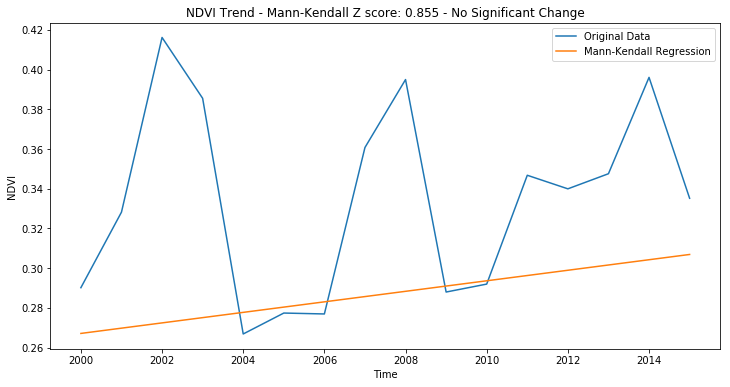

In [25]:
z_score = mann_kendall_test(regressor_time_pre_fmt, regressor_X)

z_score_label = None
if z_score < -1.96:
    z_score_label = "Potential Degradation"
if (-1.96 < z_score) and (z_score < 1.96):
    z_score_label = "No Significant Change"
if 1.96 < z_score:
    z_score_label = "Potential Improvement"

plt.figure(figsize=(12,6))
plt.plot(regressor_time_pre_fmt, regressor_X, label='Original Data')
plt.plot(regressor_time_pre_fmt, regressor.predict(regressor_time), label='Mann-Kendall Regression')
plt.legend()
plt.title("NDVI Trend - Mann-Kendall Z score: {:.3f} - {}".format(z_score, z_score_label))
plt.xlabel("Time")
plt.ylabel("NDVI")
plt.show()